In [116]:
from GA4Graph import *
from scipy.integrate import odeint
from load_files import *
from get_system_equations import system_equations
from Test_amplifier import simulate, Amplifier
from pymoo.algorithms.soo.nonconvex.ga import GA, FitnessSurvival

import matplotlib.pyplot as plt
import scipy.stats as ss
from itertools import chain

## Sampling

In [10]:
def check_valid(g, num_parts):
    graph_parts = [i[0] for i in g.nodes]
    if ('P' not in graph_parts) or ('R' not in graph_parts) or ('Z' not in graph_parts):
        return 0
    elif (len(graph_parts) - 2) < num_parts:
        return 0

    for n in g.nodes:
        if n[0] == 'P':
            out_types = set([i[0] for i in list(g.successors(n))])
            if 'Z' not in out_types:
                return 0
        elif n[0] == 'R':
            in_types = set([i[0] for i in list(g.predecessors(n))])
            if (not in_types) or (('I' in in_types) and ('Z' not in in_types)):
                return 0
        else:
            if (n[0] == 'Z') and ('I' + n[1:] in g.nodes):
                if list(g.successors(n)) != list(g.successors('I' + n[1:])):
                    return 0
            in_nodes = list(g.predecessors(n))
            if not in_nodes:
                return 0
            elif in_nodes == [n]:
                return 0
            else:
                in_types = set([i[0] for i in in_nodes])
                if ('I' in in_types) and ('Z' not in in_types):
                    return 0
            if len(list(nx.all_simple_paths(g, n, 'Rep'))) == 0:
                return 0
    return 1

In [32]:
def get_edges(promo_node, part_list):
    circuit_tf_list = [] 
    same_list = []
    for k in part_list:
        if k[0] == 'Z':
            circuit_tf_list.append(k)
            if ('I'+k[1:]) in part_list:
                same_list.append([k, ('I'+k[1:])])
    edge_list = set([(promo_node, np.random.choice(circuit_tf_list)), (np.random.choice(circuit_tf_list), 'Rep')])
    for n in part_list:
        in_edges = get_in_path(n, promo_node, circuit_tf_list)
        edge_list.update(in_edges)
        if n not in same_list:
            out_edges = get_out_path(n, part_list)
        edge_list.update(out_edges)
        
    for z, i in same_list:
        out_edges = get_out_path(i, part_list)
        edge_list.update(out_edges)
        edge_list.update([(z, k[1]) for k in out_edges])
        
    return list(edge_list)

In [45]:
def sampling(promo_node, num_dict, min_dose, max_dose, dose_interval, inhibitor=False):
    combo = []
    for num_part, num_circuit in num_dict.items():
        if not inhibitor:
            part_combo = list(combinations(tf_list, num_part))
            ind = np.random.choice(len(part_combo), num_circuit)
            combo.extend([part_combo[i] for i in ind])
        else:
            #for num_part in range(2, max_part + 1):
            for num_tf in range(1, num_part):
                num_in = num_part - num_tf
                list1 = combinations(tf_list, num_tf)
                list2 = combinations(inhibitor_list, num_in)
                part_combo = [(i[0] + i[1]) for i in list(product(list1, list2))]
                ind = np.random.choice(len(part_combo), num_circuit)
                combo.extend([part_combo[i] for i in ind])

    circuits = []

    for i in range(len(combo)):
        part_list = combo[i]
        # full_edge_list = get_full_connected(part_list, promo_node)
        edge_list = get_edges(promo_node, list(part_list))
        dose_list = dict(zip(part_list, get_dose(min_dose, max_dose, dose_interval, len(part_list))))
        circuits.append([Topo(edge_list, dose_list, promo_node)])
        
    return np.asarray(circuits)

In [46]:
promo_node = 'P1'
num_dict = {1:10, 2:20}
min_dose = 75
max_dose = 75
dose_interval = 5

In [104]:
num_circuits = sum(list(num_dict.values()))

In [47]:
np.random.seed(0)
population = sampling(promo_node, num_dict, min_dose, max_dose, dose_interval)

In [48]:
obj = np.asarray([-simulate(g[0])/Ref[g[0].promo_node]['on'] for g in population])

In [49]:
def is_equal(x1, x2):
    return compare_circuit(x1[0], x2[0])


def crossover(problem, X, **kwargs):
    X = X[np.newaxis, :].reshape(2, -1, 1)
    # The input of has the following shape (n_parents, n_matings, n_var)
    _, n_matings, n_var = X.shape
    Y = np.full_like(X, None, dtype=object)
    for k in range(n_matings):
        # get the first and the second parent
        parent1, parent2 = X[0, k, 0], X[1, k, 0]
        Y[0, k, 0], Y[1, k, 0] = crossover_structure(parent1, parent2)
    return Y.reshape(-1, 1)

In [51]:
children = crossover(None, population)
obj_children = np.asarray([-simulate(g[0])/Ref[g[0].promo_node]['on'] for g in children])

## Genotypic diversity

In [53]:
def compare(X):
    dupes_dict = dict()
    for i, g in enumerate(X):
        if i not in list(chain.from_iterable(dupes_dict.values())):
            dupes_dict.update({i: [j for j in range(i+1, len(X)) if is_equal(g, X[j])]})
    return len(dupes_dict)

In [54]:
compare(population)

25

In [55]:
compare(children)

28

## Phenotypic diversity

Text(0.5, 1.0, 'Children')

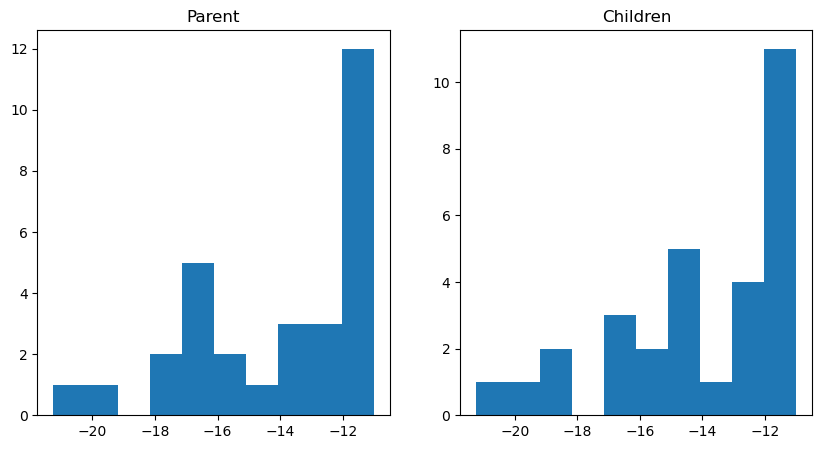

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(obj);
axes[0].set_title("Parent")
axes[1].hist(obj_children);
axes[1].set_title("Children")

In [148]:
delta = 0.5

def grouping(F, delta=0.5):
    bins = np.arange(np.min(F), np.max(F)+delta, delta)
    n = np.full_like(F, 0)
    for i in range(len(F)):
        n[i] = np.argwhere(F[i] >= bins).flatten()[-1]
    return n, bins

In [58]:
n, bins = grouping(obj, delta)

In [59]:
n_children, bins_children = grouping(obj_children, delta)

In [60]:
len(set(n))

13

In [61]:
len(set(n_children))

16

In [147]:
def pheno_diversity(F, delta=0.5):
    n, bins = grouping(F, delta)
    return len(set(n))

## Entropy

In [62]:
_, p = np.unique(n, return_counts=True)
p = p/len(p)

In [63]:
entropy = -np.sum(p*np.log(p)) 
entropy

3.2739767923382828

In [64]:
_, p_children = np.unique(n_children, return_counts=True)
p_children = p_children/len(p_children)

In [65]:
entropy = -np.sum(p_children*np.log(p_children)) 
entropy

3.5905277177534467

In [146]:
def get_entropy(n):
    _, p = np.unique(n, return_counts=True)
    p = p/len(p)
    entropy = -np.sum(p*np.log(p)) 
    return entropy

## Pseudo-isomorphs

In [66]:
def pseudo_iso(g):
    p_out = len(list(g.graph.successors('P1')))
    rep_in = len(list(g.graph.predecessors('Rep')))
    size = g.graph.size()
    return p_out, rep_in, size

In [67]:
iso = np.unique(np.asarray([pseudo_iso(g[0]) for g in population]), axis=0, return_counts=True)
len(iso[0])

7

In [68]:
iso_children = np.unique(np.asarray([pseudo_iso(g[0]) for g in children]), axis=0, return_counts=True)
len(iso_children[0])

5

5

## Edit distance

In [98]:
ind_parent = np.argmin(obj)

In [99]:
ind_parent

9

In [149]:
def get_edit_distance(population, ind):
    ed1 = np.zeros(population.shape[0])
    for i in range(population.shape[0]):
        ed1[i] = nx.graph_edit_distance(population[i][0].graph, population[ind][0].graph)
    return ed1

In [111]:
np.mean(ed1)

2.7666666666666666

In [112]:
np.max(ed1)

5.0

In [113]:
np.median(ed1)

3.0

In [118]:
survive = FitnessSurvival()

In [124]:
S

array([ 9, 23, 11, 17,  2,  4,  7, 24, 25, 28, 16,  6, 21, 19, 27, 10, 26,
       20,  0,  8, 15, 14,  3,  1, 18,  5, 22, 12, 13, 29])

In [122]:
len(S)

30

In [123]:
np.argsort(S)

array([18, 23,  4, 22,  5, 25, 11,  6, 19,  0, 15,  2, 27, 28, 21, 20, 10,
        3, 24, 13, 17, 12, 26,  1,  7,  8, 16, 14,  9, 29])

In [127]:
obj = np.append(obj, obj_children)

In [130]:
S

array([ 9, 32, 54, 23, 34, 39, 11, 17, 41, 43,  2,  4,  7, 24, 25, 46, 28,
       16, 49, 40,  6, 36, 53, 51, 57, 47, 21, 19, 27, 56, 52, 59, 10, 26,
       30, 20, 33,  0,  8, 15, 14, 35,  3, 31,  1, 50, 45, 18,  5, 48, 44,
       55, 22, 38, 12, 58, 42, 13, 29, 37])

In [133]:
obj_new = obj[S[:num_circuits]]

In [135]:
len(obj_new)

30

In [240]:
n_gen = 20
prob = 1

In [231]:
num_dict = {1:10, 2:40}

In [242]:
# np.random.seed(0)
population = sampling(promo_node, num_dict, min_dose, max_dose, dose_interval)
obj = np.asarray([-simulate(g[0])/Ref[g[0].promo_node]['on'] for g in population])

obj_min = np.zeros(n_gen+1)
circuit_min = []

geno = np.zeros(n_gen+1)
pheno = np.zeros_like(geno)
entropy = np.zeros_like(geno)
iso = np.zeros_like(geno)
ed_mean = np.zeros_like(geno)
ed_max = np.zeros_like(geno)
ed_median = np.zeros_like(geno)

geno[0] = compare(population)
n, bins = grouping(obj, 0.5)
entropy[0] = get_entropy(n)
pheno[0] = len(set(n))
iso[0] = len(np.unique(np.asarray([pseudo_iso(g[0]) for g in population]), axis=0))
ind_min = np.argmin(obj)
ed1 = get_edit_distance(population, ind_min)
ed_mean[0] = np.mean(ed1)
ed_max[0] = max(ed1)
ed_median[0] = np.median(ed1)

ind_min = np.argmin(obj)
obj_min[0] = obj[ind_min]
circuit_min.append(population[ind_min])

In [243]:
for gen in range(n_gen):
    if np.random.uniform() < 0.5:
        children = crossover(None, population)
        obj_children = np.asarray([-simulate(g[0])/Ref[g[0].promo_node]['on'] for g in children])
        obj = np.append(obj, obj_children)
        population = np.vstack((population, children))
        S = np.lexsort([obj])
        obj = obj[S[:num_circuits]]
        population = population[S[:num_circuits], :]
    
    geno[gen+1] = compare(population)
    n, bins = grouping(obj, 0.5)
    entropy[gen+1] = get_entropy(n)
    pheno[gen+1] = len(set(n))
    iso[gen+1] = len(np.unique(np.asarray([pseudo_iso(g[0]) for g in population]), axis=0))
    ind_min = np.argmin(obj)
    ed1 = get_edit_distance(population, ind_min)
    ed_mean[gen+1] = np.mean(ed1)
    ed_max[gen+1] = max(ed1)
    ed_median[gen+1] = np.median(ed1)
    
    obj_min[gen+1] = obj[ind_min]
    circuit_min.append(population[ind_min])

In [234]:
generations = np.arange(n_gen+1)

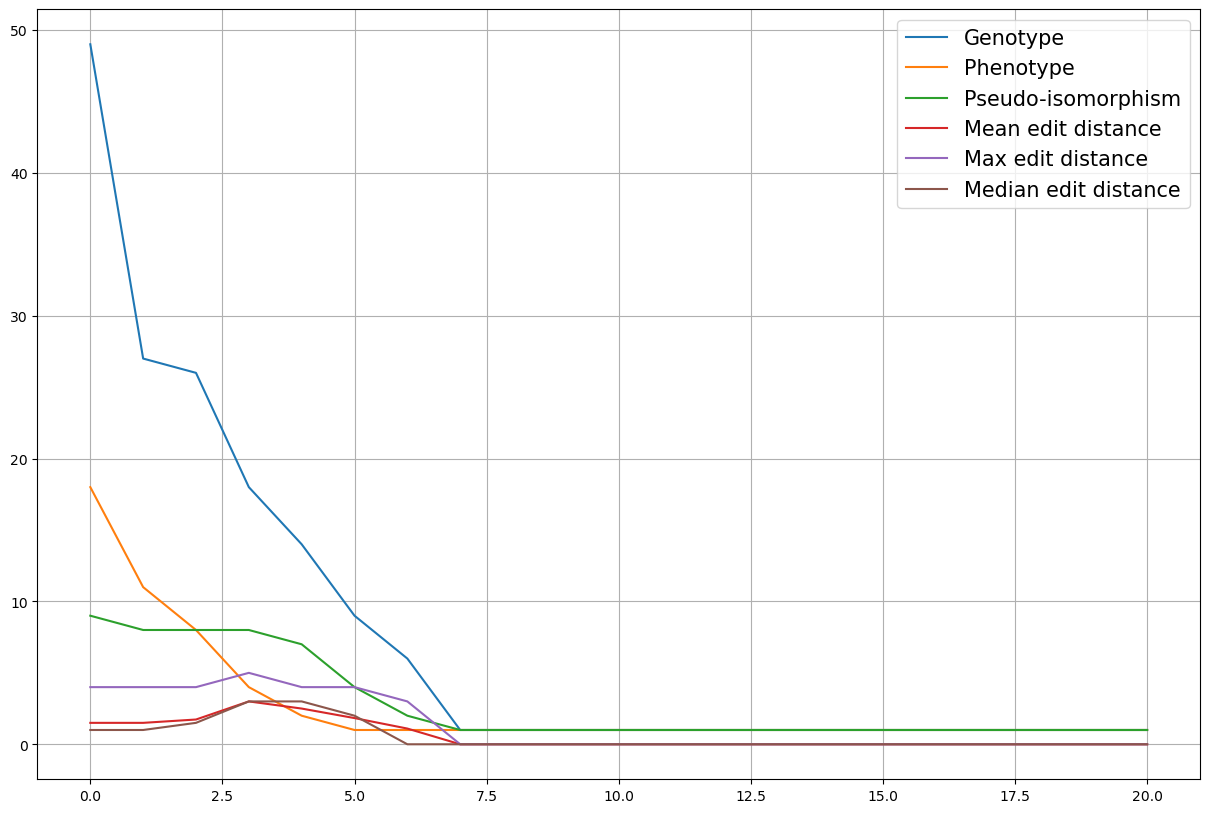

In [237]:
plt.figure(figsize=(15,10))
plt.plot(generations, geno, label='Genotype')
plt.plot(generations, pheno, label='Phenotype')
plt.plot(generations, iso, label='Pseudo-isomorphism')
plt.plot(generations, ed_mean, label='Mean edit distance')
plt.plot(generations, ed_max, label='Max edit distance')
plt.plot(generations, ed_median, label='Median edit distance')
plt.grid(True)
plt.legend(fontsize=15)

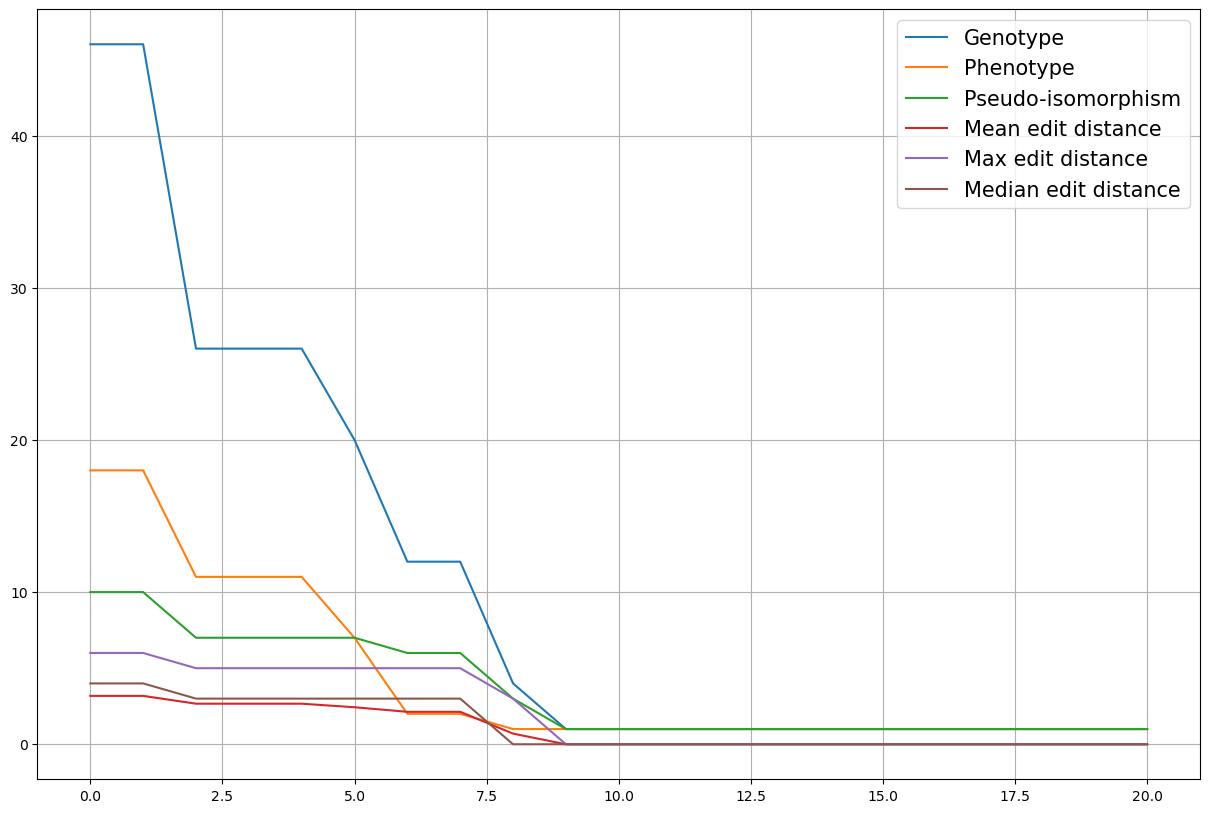

In [244]:
plt.figure(figsize=(15,10))
plt.plot(generations, geno, label='Genotype')
plt.plot(generations, pheno, label='Phenotype')
plt.plot(generations, iso, label='Pseudo-isomorphism')
plt.plot(generations, ed_mean, label='Mean edit distance')
plt.plot(generations, ed_max, label='Max edit distance')
plt.plot(generations, ed_median, label='Median edit distance')
plt.grid(True)
plt.legend(fontsize=15)

In [218]:
obj_rank = ss.rankdata(obj_min, method='dense')

geno_rank = ss.rankdata(geno, method='dense')
pheno_rank = ss.rankdata(pheno, method='dense')
iso_rank = ss.rankdata(iso, method='dense')
ed_mean_rank = ss.rankdata(ed_mean, method='dense')
ed_max_rank = ss.rankdata(ed_max, method='dense')
ed_median_rank = ss.rankdata(ed_median, method='dense')

In [219]:
def Spearman(x1, x2):
    d = (x1-x2)
    n = len(d)
    rho = 1- 6./(n*(n**2-1)) * np.sum(d**2)
    return rho

In [246]:
Spearman(obj_rank, geno_rank)

0.9467532467532468

In [247]:
Spearman(obj_rank, pheno_rank)

0.9850649350649351

In [248]:
Spearman(obj_rank, iso_rank)

0.9642857142857143

In [249]:
Spearman(obj_rank, ed_mean_rank)

0.9454545454545454

In [250]:
Spearman(obj_rank, ed_max_rank)

0.962987012987013

In [251]:
Spearman(obj_rank, ed_median_rank)

0.9844155844155844

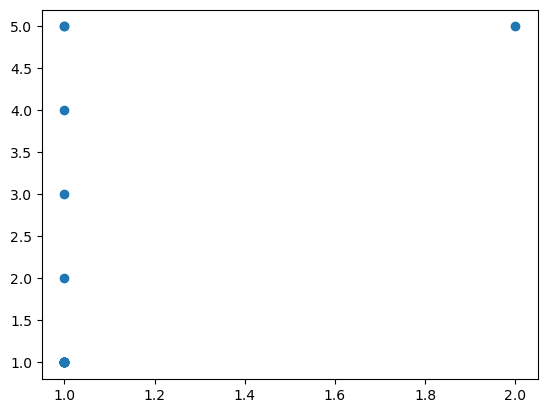

In [252]:
plt.scatter(obj_rank, iso_rank)

In [227]:
population

array([[<define_circuit.Topo object at 0x7fcfc9a38fd0>],
       [<define_circuit.Topo object at 0x7fcfc9a41210>]], dtype=object)

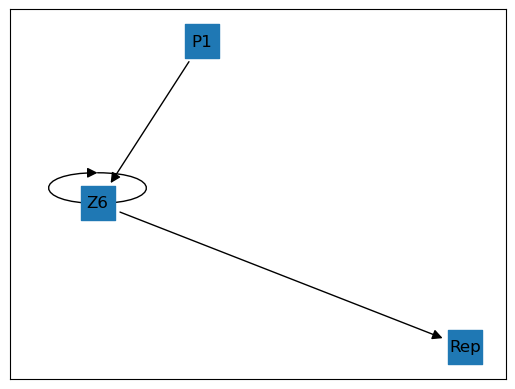

In [245]:
population[0][0].plot_graph()